# House Price Prediction System - Model Development

## Project Overview
This notebook implements a production-grade house price prediction model using Random Forest Regressor.

**Selected Features:**
- OverallQual: Overall material and finish quality
- GrLivArea: Above grade (ground) living area square feet
- TotalBsmtSF: Total square feet of basement area
- GarageCars: Size of garage in car capacity
- YearBuilt: Original construction date
- Neighborhood: Physical locations within Ames city limits

**Algorithm:** Random Forest Regressor (robust, handles non-linear relationships, reduces overfitting)

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

Load the House Prices dataset. 
**Note:** Download the dataset from Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [5]:
# Load the dataset
try:
    df = pd.read_csv('train.csv')
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"\nFirst few rows:")
    display(df.head())
except FileNotFoundError:
    print("ERROR: train.csv not found!")
    print("Please download the dataset from Kaggle and place it in the model/ directory.")
    print("URL: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data")

Dataset loaded successfully!
Shape: (1460, 81)

First few rows:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Data Exploration

In [6]:
# Select only the required features
SELECTED_FEATURES = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt', 'Neighborhood']
TARGET = 'SalePrice'

# Create a subset with selected features and target
df_subset = df[SELECTED_FEATURES + [TARGET]].copy()

print("Selected Features Dataset Info:")
print(f"Shape: {df_subset.shape}")
print(f"\nData types:")
print(df_subset.dtypes)
print(f"\nBasic statistics:")
display(df_subset.describe())

Selected Features Dataset Info:
Shape: (1460, 7)

Data types:
OverallQual      int64
GrLivArea        int64
TotalBsmtSF      int64
GarageCars       int64
YearBuilt        int64
Neighborhood    object
SalePrice        int64
dtype: object

Basic statistics:


,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,YearBuilt,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1057.429452,1.767123,1971.267808,180921.195890
std,1.382997,525.480383,438.705324,0.747315,30.202904,79442.502883
min,1.000000,334.000000,0.000000,0.000000,1872.000000,34900.000000
25%,5.000000,1129.500000,795.750000,1.000000,1954.000000,129975.000000
50%,6.000000,1464.000000,991.500000,2.000000,1973.000000,163000.000000
75%,7.000000,1776.750000,1298.250000,2.000000,2000.000000,214000.000000
max,10.000000,5642.000000,6110.000000,4.000000,2010.000000,755000.000000


In [7]:
# Check for missing values
print("Missing Values:")
missing_data = df_subset.isnull().sum()
missing_percent = (df_subset.isnull().sum() / len(df_subset)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
display(missing_df)

if len(missing_df) == 0:
    print("\n✓ No missing values found!")
else:
    print(f"\n⚠ Found missing values in {len(missing_df)} features")

Missing Values:


,Missing Count,Percentage



✓ No missing values found!


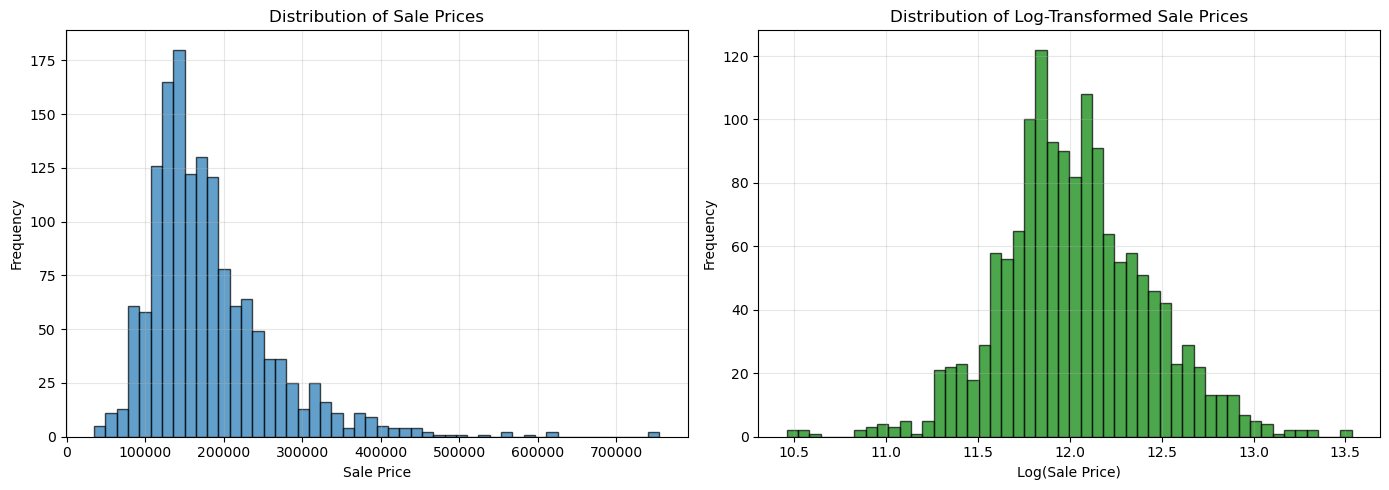

Sale Price Statistics:
Mean: $180,921.20
Median: $163,000.00
Min: $34,900.00
Max: $755,000.00


In [8]:
# Visualize target variable distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df_subset[TARGET], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Prices')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_subset[TARGET]), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Log(Sale Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Sale Prices')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sale Price Statistics:")
print(f"Mean: ${df_subset[TARGET].mean():,.2f}")
print(f"Median: ${df_subset[TARGET].median():,.2f}")
print(f"Min: ${df_subset[TARGET].min():,.2f}")
print(f"Max: ${df_subset[TARGET].max():,.2f}")

## 3. Data Preprocessing

In [9]:
# Handle missing values
print("Handling Missing Values...")

# For TotalBsmtSF and GarageCars, missing values likely mean "no basement" or "no garage"
df_subset['TotalBsmtSF'].fillna(0, inplace=True)
df_subset['GarageCars'].fillna(0, inplace=True)

# Drop any remaining rows with missing values (if any)
initial_rows = len(df_subset)
df_subset.dropna(inplace=True)
final_rows = len(df_subset)

print(f"✓ Missing values handled")
print(f"  Initial rows: {initial_rows}")
print(f"  Final rows: {final_rows}")
print(f"  Rows dropped: {initial_rows - final_rows}")

# Verify no missing values remain
assert df_subset.isnull().sum().sum() == 0, "ERROR: Missing values still present!"
print("\n✓ Verification passed: No missing values remain")

Handling Missing Values...
✓ Missing values handled
  Initial rows: 1460
  Final rows: 1460
  Rows dropped: 0

✓ Verification passed: No missing values remain


In [10]:
# Encode categorical variables (Neighborhood)
print("Encoding Categorical Variables...")
print(f"\nUnique Neighborhoods: {df_subset['Neighborhood'].nunique()}")
print(df_subset['Neighborhood'].value_counts().head(10))

# Use Label Encoder for Neighborhood
label_encoder = LabelEncoder()
df_subset['Neighborhood_Encoded'] = label_encoder.fit_transform(df_subset['Neighborhood'])

print("\n✓ Categorical encoding completed")
print(f"  Neighborhood encoded to numerical values (0-{df_subset['Neighborhood_Encoded'].max()})")

Encoding Categorical Variables...

Unique Neighborhoods: 25
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
Name: count, dtype: int64

✓ Categorical encoding completed
  Neighborhood encoded to numerical values (0-24)


In [11]:
# Prepare features and target
# Use encoded neighborhood instead of original
feature_cols = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt', 'Neighborhood_Encoded']

X = df_subset[feature_cols].copy()
y = df_subset[TARGET].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_cols}")

Features shape: (1460, 6)
Target shape: (1460,)

Feature columns: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt', 'Neighborhood_Encoded']


In [12]:
# Feature Scaling (StandardScaler)
print("Applying Feature Scaling...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("✓ Feature scaling completed")
print("\nScaled features sample:")
display(X_scaled.head())

Applying Feature Scaling...
✓ Feature scaling completed

Scaled features sample:


,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,YearBuilt,Neighborhood_Encoded
0,0.651479,0.370333,-0.459303,0.311725,1.050994,-1.206215
1,-0.071836,-0.482512,0.466465,0.311725,0.156734,1.954302
2,0.651479,0.515013,-0.313369,0.311725,0.984752,-1.206215
3,0.651479,0.383659,-0.687324,1.650307,-1.863632,-1.039872
4,1.374795,1.299326,0.199680,1.650307,0.951632,0.457215


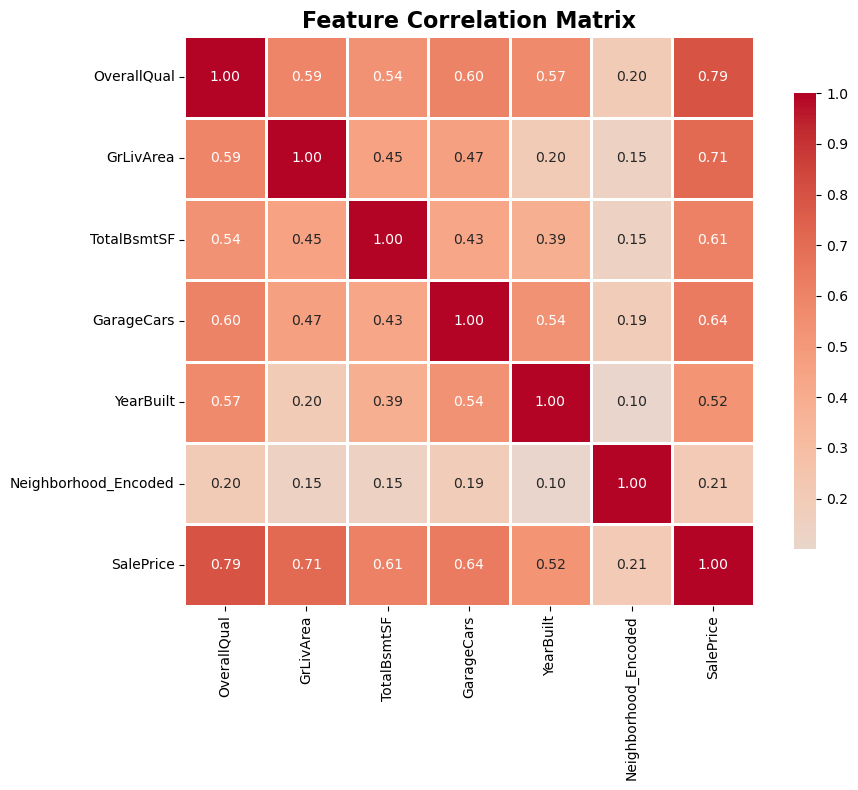

Correlation with Target (SalePrice):
SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
TotalBsmtSF             0.613581
YearBuilt               0.522897
Neighborhood_Encoded    0.210851
Name: SalePrice, dtype: float64


In [13]:
# Correlation analysis
correlation_data = df_subset[feature_cols + [TARGET]].copy()
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation with Target (SalePrice):")
print(correlation_matrix[TARGET].sort_values(ascending=False))

## 4. Train-Test Split

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Train-Test Split:")
print(f"Training set: {X_train.shape[0]} samples ({(X_train.shape[0]/len(X_scaled))*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]} samples ({(X_test.shape[0]/len(X_scaled))*100:.1f}%)")
print(f"\nFeatures: {X_train.shape[1]}")

Train-Test Split:
Training set: 1168 samples (80.0%)
Testing set: 292 samples (20.0%)

Features: 6


## 5. Model Training - Random Forest Regressor

In [15]:
# Initialize and train Random Forest Regressor
print("Training Random Forest Regressor...\n")

# Initial model with good default parameters
rf_model = RandomForestRegressor(
    n_estimators=200,          # Number of trees
    max_depth=15,              # Maximum depth of trees
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=2,        # Minimum samples in leaf node
    max_features='sqrt',       # Number of features for best split
    random_state=42,
    n_jobs=-1,                 # Use all CPU cores
    verbose=1
)

# Train the model
rf_model.fit(X_train, y_train)

print("\n✓ Model training completed!")

Training Random Forest Regressor...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s



✓ Model training completed!


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished


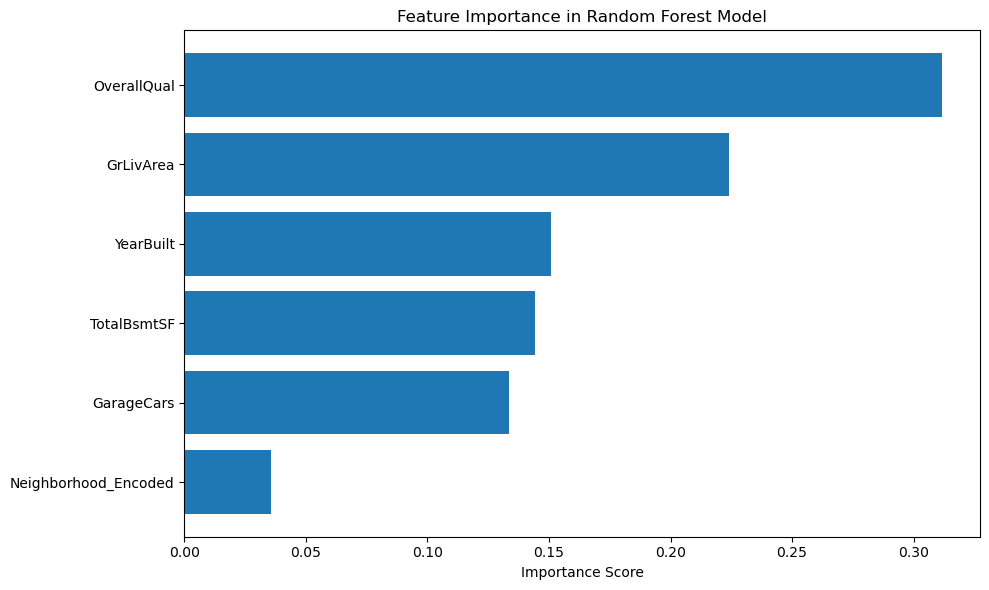

Feature Importance Rankings:


,Feature,Importance
0,OverallQual,0.311753
1,GrLivArea,0.224144
4,YearBuilt,0.150805
2,TotalBsmtSF,0.144155
3,GarageCars,0.133672
5,Neighborhood_Encoded,0.035470


In [16]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Feature Importance Rankings:")
display(feature_importance)

## 6. Model Evaluation

In [17]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("Model Predictions Generated")
print(f"Training predictions: {len(y_train_pred)}")
print(f"Testing predictions: {len(y_test_pred)}")

Model Predictions Generated
Training predictions: 1168
Testing predictions: 292


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [18]:
# Calculate evaluation metrics
def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    """
    Calculate and display regression metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"{dataset_name} Performance Metrics")
    print(f"{'='*50}")
    print(f"Mean Absolute Error (MAE):     ${mae:,.2f}")
    print(f"Mean Squared Error (MSE):      ${mse:,.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
    print(f"R² Score:                       {r2:.4f} ({r2*100:.2f}%)")
    print(f"{'='*50}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Evaluate on training set
train_metrics = evaluate_model(y_train, y_train_pred, "Training Set")

# Evaluate on testing set
test_metrics = evaluate_model(y_test, y_test_pred, "Testing Set")


Training Set Performance Metrics
Mean Absolute Error (MAE):     $11,995.31
Mean Squared Error (MSE):      $379,352,331.52
Root Mean Squared Error (RMSE): $19,476.97
R² Score:                       0.9364 (93.64%)

Testing Set Performance Metrics
Mean Absolute Error (MAE):     $18,491.17
Mean Squared Error (MSE):      $898,065,782.58
Root Mean Squared Error (RMSE): $29,967.75
R² Score:                       0.8829 (88.29%)


In [19]:
# Cross-validation score
print("\nPerforming 5-Fold Cross-Validation...")
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5, 
                           scoring='r2', n_jobs=-1)

print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Performing 5-Fold Cross-Validation...

Cross-Validation R² Scores: [0.86402837 0.82626694 0.85280834 0.87941904 0.82836697]
Mean CV R² Score: 0.8502 (±0.0205)


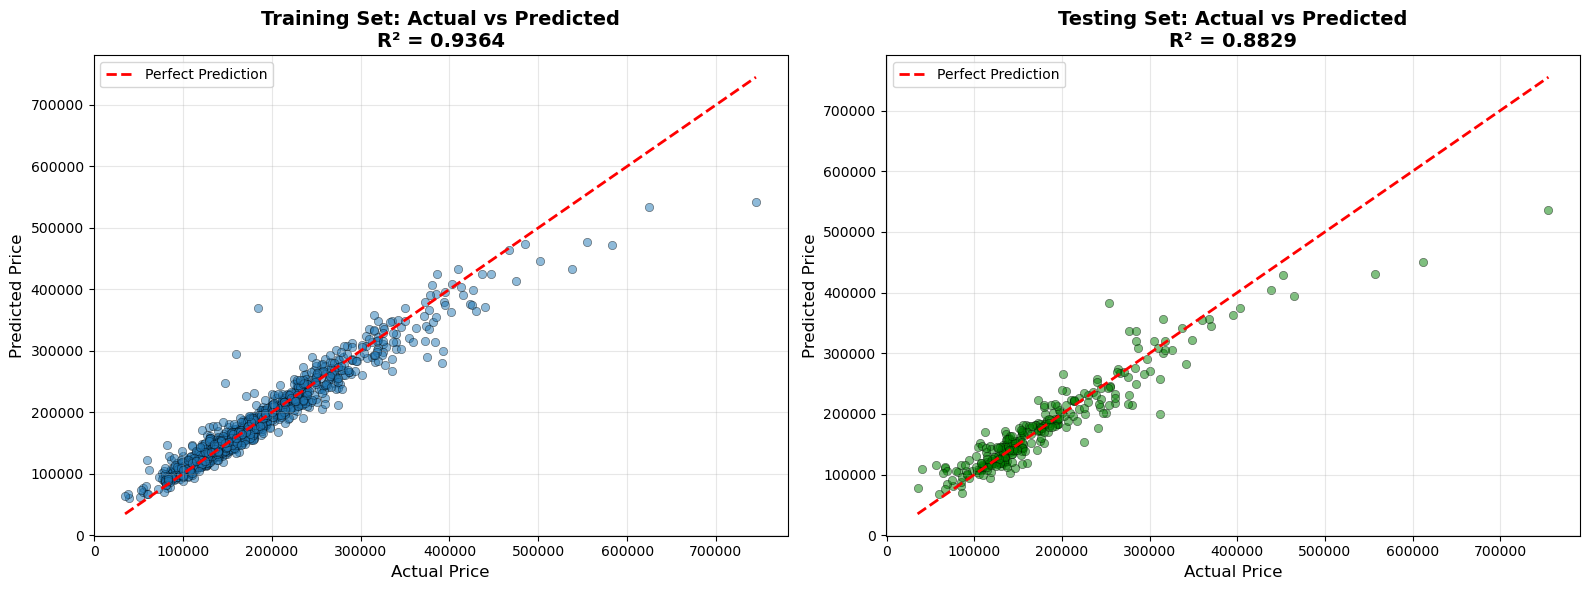

In [20]:
# Visualization: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price', fontsize=12)
axes[0].set_ylabel('Predicted Price', fontsize=12)
axes[0].set_title(f'Training Set: Actual vs Predicted\nR² = {train_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Testing set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price', fontsize=12)
axes[1].set_ylabel('Predicted Price', fontsize=12)
axes[1].set_title(f'Testing Set: Actual vs Predicted\nR² = {test_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

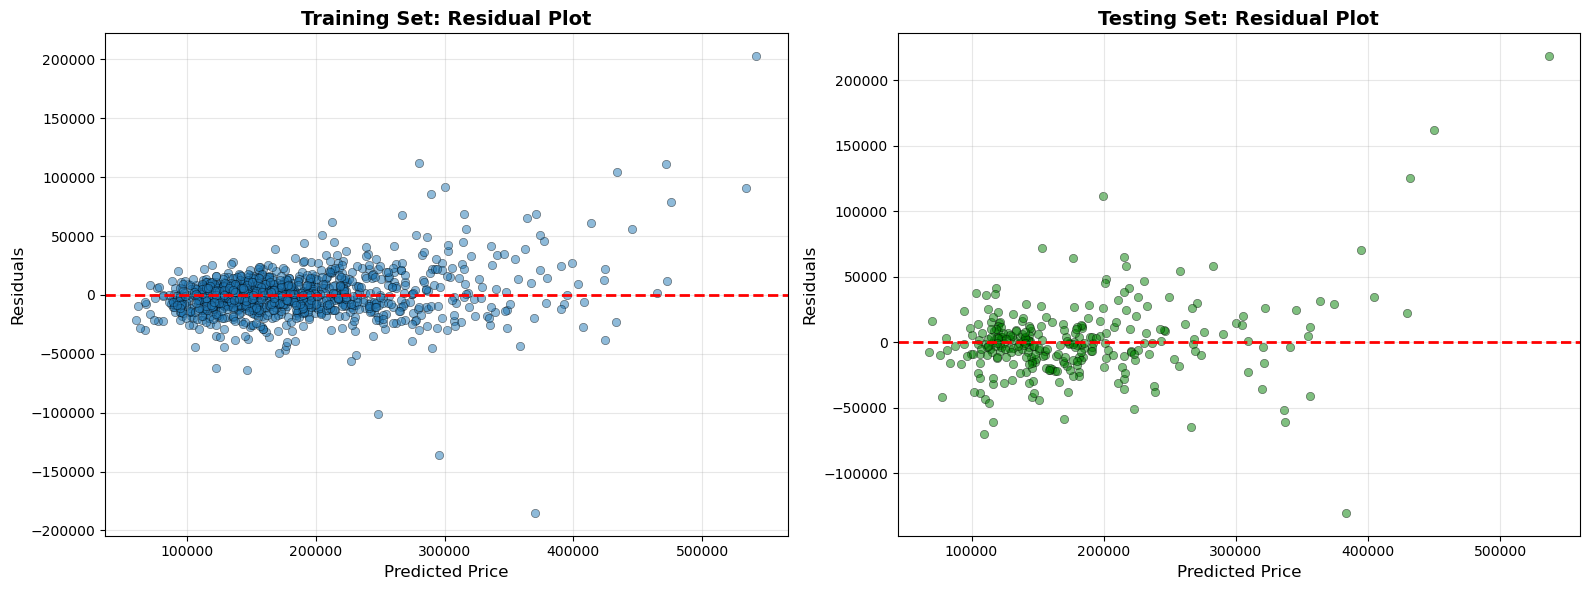

In [21]:
# Residual analysis
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training residuals
axes[0].scatter(y_train_pred, residuals_train, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Training Set: Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Testing residuals
axes[1].scatter(y_test_pred, residuals_test, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Testing Set: Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Persistence - Save Model and Preprocessing Objects

In [22]:
# Save the trained model and preprocessing objects
print("Saving model and preprocessing objects...\n")

# Create a model package with all necessary components
model_package = {
    'model': rf_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_columns': feature_cols,
    'selected_features': SELECTED_FEATURES,
    'metrics': {
        'train': train_metrics,
        'test': test_metrics,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    },
    'neighborhoods': label_encoder.classes_.tolist()
}

# Save using joblib (more efficient for scikit-learn models)
joblib.dump(model_package, 'house_price_model.pkl', compress=3)

print("✓ Model package saved successfully as 'house_price_model.pkl'")
print("\nPackage contents:")
print("  - Trained Random Forest model")
print("  - StandardScaler for feature scaling")
print("  - LabelEncoder for Neighborhood encoding")
print("  - Feature column names")
print("  - Performance metrics")
print("  - Neighborhood mappings")

Saving model and preprocessing objects...

✓ Model package saved successfully as 'house_price_model.pkl'

Package contents:
  - Trained Random Forest model
  - StandardScaler for feature scaling
  - LabelEncoder for Neighborhood encoding
  - Feature column names
  - Performance metrics
  - Neighborhood mappings


In [23]:
# Verify model can be loaded
print("\nVerifying model persistence...")

loaded_package = joblib.load('house_price_model.pkl')
loaded_model = loaded_package['model']

# Test prediction with loaded model
test_prediction = loaded_model.predict(X_test[:5])

print("✓ Model loaded successfully!")
print(f"\nTest predictions from loaded model:")
for i, (pred, actual) in enumerate(zip(test_prediction, y_test.values[:5]), 1):
    print(f"  Sample {i}: Predicted=${pred:,.2f}, Actual=${actual:,.2f}, Error=${abs(pred-actual):,.2f}")


Verifying model persistence...
✓ Model loaded successfully!

Test predictions from loaded model:
  Sample 1: Predicted=$138,199.14, Actual=$154,500.00, Error=$16,300.86
  Sample 2: Predicted=$305,150.37, Actual=$325,000.00, Error=$19,849.63
  Sample 3: Predicted=$115,544.95, Actual=$115,000.00, Error=$544.95
  Sample 4: Predicted=$181,515.52, Actual=$159,000.00, Error=$22,515.52
  Sample 5: Predicted=$300,390.68, Actual=$315,500.00, Error=$15,109.32


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


## 8. Example Usage for Web Application

In [24]:
# Demonstrate how to use the saved model for predictions
def predict_house_price(overall_qual, gr_liv_area, total_bsmt_sf, 
                       garage_cars, year_built, neighborhood):
    """
    Predict house price given input features
    
    Args:
        overall_qual: Overall material and finish quality (1-10)
        gr_liv_area: Above grade living area (sq ft)
        total_bsmt_sf: Total basement area (sq ft)
        garage_cars: Garage size in car capacity (0-4)
        year_built: Original construction year
        neighborhood: Neighborhood name (string)
    
    Returns:
        Predicted house price
    """
    # Load the model package
    package = joblib.load('house_price_model.pkl')
    model = package['model']
    scaler = package['scaler']
    encoder = package['label_encoder']
    
    # Encode neighborhood
    try:
        neighborhood_encoded = encoder.transform([neighborhood])[0]
    except:
        # If neighborhood not found, use most common one
        neighborhood_encoded = 0
        print(f"Warning: Neighborhood '{neighborhood}' not found, using default")
    
    # Create feature array
    features = np.array([[overall_qual, gr_liv_area, total_bsmt_sf, 
                         garage_cars, year_built, neighborhood_encoded]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    
    return prediction

# Test the function
print("Testing prediction function...\n")

# Example 1: High-end house
price1 = predict_house_price(
    overall_qual=8,
    gr_liv_area=2500,
    total_bsmt_sf=1500,
    garage_cars=2,
    year_built=2005,
    neighborhood='NoRidge'
)
print(f"Example 1 - High-end house: ${price1:,.2f}")

# Example 2: Mid-range house
price2 = predict_house_price(
    overall_qual=5,
    gr_liv_area=1500,
    total_bsmt_sf=800,
    garage_cars=1,
    year_built=1990,
    neighborhood='NAmes'
)
print(f"Example 2 - Mid-range house: ${price2:,.2f}")

# Example 3: Budget house
price3 = predict_house_price(
    overall_qual=4,
    gr_liv_area=1000,
    total_bsmt_sf=500,
    garage_cars=0,
    year_built=1970,
    neighborhood='OldTown'
)
print(f"Example 3 - Budget house: ${price3:,.2f}")

Testing prediction function...



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Example 1 - High-end house: $296,695.92


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Example 2 - Mid-range house: $150,854.89
Example 3 - Budget house: $95,266.54


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


## 9. Model Summary and Conclusions

In [25]:
print("="*70)
print("HOUSE PRICE PREDICTION MODEL - FINAL SUMMARY")
print("="*70)
print(f"\nAlgorithm: Random Forest Regressor")
print(f"Features Used: {len(SELECTED_FEATURES)}")
print(f"  - {', '.join(SELECTED_FEATURES)}")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print(f"\n{'Performance Metrics':^70}")
print("-"*70)
print(f"{'Metric':<30} {'Training':<20} {'Testing':<20}")
print("-"*70)
print(f"{'R² Score':<30} {train_metrics['R2']:<20.4f} {test_metrics['R2']:<20.4f}")
print(f"{'RMSE':<30} ${train_metrics['RMSE']:<19,.2f} ${test_metrics['RMSE']:<19,.2f}")
print(f"{'MAE':<30} ${train_metrics['MAE']:<19,.2f} ${test_metrics['MAE']:<19,.2f}")
print("-"*70)
print(f"\nCross-Validation R² (5-fold): {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"\nModel Status: Ready for deployment")
print(f"Model File: house_price_model.pkl")
print(f"Persistence Method: Joblib")
print("="*70)

# Model quality assessment
r2_test = test_metrics['R2']
if r2_test >= 0.8:
    quality = "Excellent"
elif r2_test >= 0.7:
    quality = "Good"
elif r2_test >= 0.6:
    quality = "Fair"
else:
    quality = "Needs Improvement"

print(f"\n✓ Model Quality: {quality}")
print(f"✓ Model explains {r2_test*100:.2f}% of variance in test data")
print(f"✓ Average prediction error: ${test_metrics['MAE']:,.2f}")

HOUSE PRICE PREDICTION MODEL - FINAL SUMMARY

Algorithm: Random Forest Regressor
Features Used: 6
  - OverallQual, GrLivArea, TotalBsmtSF, GarageCars, YearBuilt, Neighborhood

Training Samples: 1168
Testing Samples: 292

                         Performance Metrics                          
----------------------------------------------------------------------
Metric                         Training             Testing             
----------------------------------------------------------------------
R² Score                       0.9364               0.8829              
RMSE                           $19,476.97           $29,967.75          
MAE                            $11,995.31           $18,491.17          
----------------------------------------------------------------------

Cross-Validation R² (5-fold): 0.8502 (±0.0205)

Model Status: Ready for deployment
Model File: house_price_model.pkl
Persistence Method: Joblib

✓ Model Quality: Excellent
✓ Model explains 88.29% of var